TODO: weight distribution after learning, do we see some synchronization effect?

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

In [6]:
sns.set_theme(context='paper', palette='colorblind', style='whitegrid')

# Spiking Neuron

In [7]:
from rsnn.neuron.neuron import Neuron

Let's first create a neuron

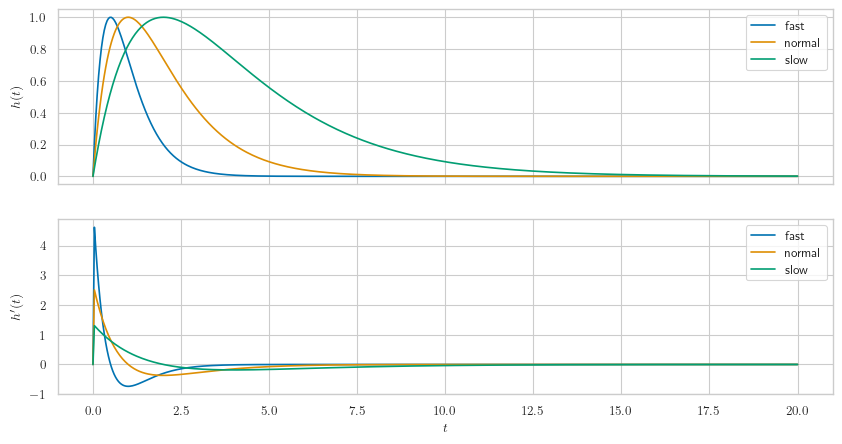

In [9]:
neuron_fast = Neuron(0, 0, input_beta=0.5)
neuron_normal = Neuron(0, 0, input_beta=1.0)
neuron_slow = Neuron(0, 0, input_beta=2.0)

t = np.linspace(0, 20, 500)

fig, axes = plt.subplots(2, 1, figsize=(10,5), sharex=True)

#axes[0,0].plot(t, neuron.weights_min * neuron.impulse_resp(t[:,None]), label="$-w_b h(t)$")
axes[0].plot(t, neuron_fast.input_kernel(t[:,None]), "C0", label="fast")
axes[0].plot(t, neuron_normal.input_kernel(t[:,None]), "C1", label="normal")
axes[0].plot(t, neuron_slow.input_kernel(t[:,None]), "C2", label="slow")
axes[0].set_ylabel("$h(t)$")
axes[0].legend()

axes[1].plot(t, neuron_fast.input_kernel_prime(t[:,None]), "C0", label="fast")
axes[1].plot(t, neuron_normal.input_kernel_prime(t[:,None]), "C1", label="normal")
axes[1].plot(t, neuron_slow.input_kernel_prime(t[:,None]), "C2", label="slow")
axes[1].set_xlabel("$t$")
axes[1].set_ylabel("$h'(t)$")
axes[1].legend()

plt.show()

## Receptive Field

In [8]:
num_inputs = 3
neuron = Neuron(0, num_inputs)

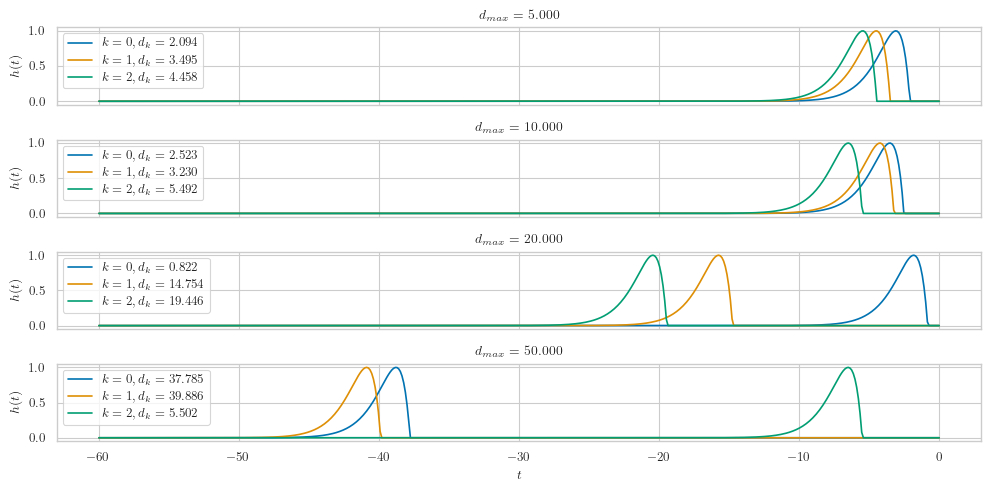

In [9]:
t = np.linspace(-60, 0, 500)

fig, axes = plt.subplots(4, 1, figsize=(10,5), sharex=True)

#axes[0,0].plot(t, neuron.weights_min * neuron.impulse_resp(t[:,None]), label="$-w_b h(t)$")
for i, dmax in enumerate([5, 10, 20, 50]):
    neuron.delays = np.random.uniform(low=0.1, high=dmax, size=num_inputs) # transmission delays
    for k in range(num_inputs):
        axes[i].plot(t, neuron.input_kernel(- t[:,None] - neuron.delays[k]), f"C{k}", label=f"$k = {k}, d_k = {neuron.delays[k]:.3f}$")

    axes[i].set_ylabel("$h(t)$")
    axes[i].set_title("$d_{max} =$" + f" ${dmax:.3f}$")
    axes[i].legend()

axes[-1].set_xlabel("$t$")
fig.tight_layout()
plt.show()

We define the overlap between two attention windows (i.e., input kernels) $h_1$ and $h_2$ at time $t$ as 
$$
    \gamma \int h_1(\tau) h_2(\tau) d\tau
$$
with $\gamma > 0$ a normalization factor and  
$$
    h_k = (t - d_k) e^{1 - (t - d_k)}
$$
for $t > d_k$.
Without loss of generality, we assume $d_1 \leq d_2$ and define $d \triangleq d_2 - d_1 \geq 0$ and obtain
$$
    \gamma \int_{d}^{\infty} h_1(t) h_2(t) \, dt = (|d| + 1) e^{-|d|}.
$$
with $\gamma = 4e^{-2}$.

In [10]:
import math
from scipy.special import lambertw

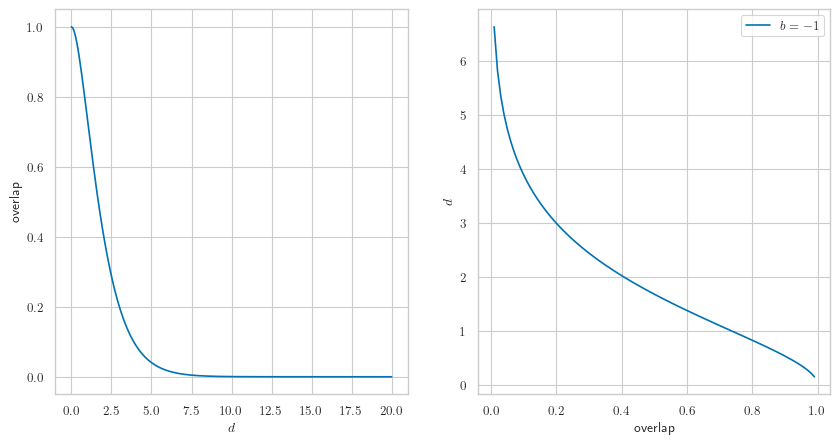

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

d = np.linspace(0, 20, 250)
axes[0].plot(d, (d+1)*np.exp(-d))
axes[0].set_ylabel("overlap")
axes[0].set_xlabel("$d$")

overlap = np.linspace(0, 1, 100)
#axes[1].plot(overlap, -np.real_if_close(lambertw(-overlap / math.e, k=0)) - 1, label="$b=0$")
axes[1].plot(overlap, -lambertw(-overlap / math.e, k=-1).real - 1, label="$b=-1$")
axes[1].set_ylabel("$d$")
axes[1].set_xlabel("overlap")
axes[1].legend()

plt.show()

Take random delays, plot the distribution of the overlap, get the expected overlap, and the probability of having large overlap as a function of the number of parallel inputs.

In [13]:
from itertools import combinations

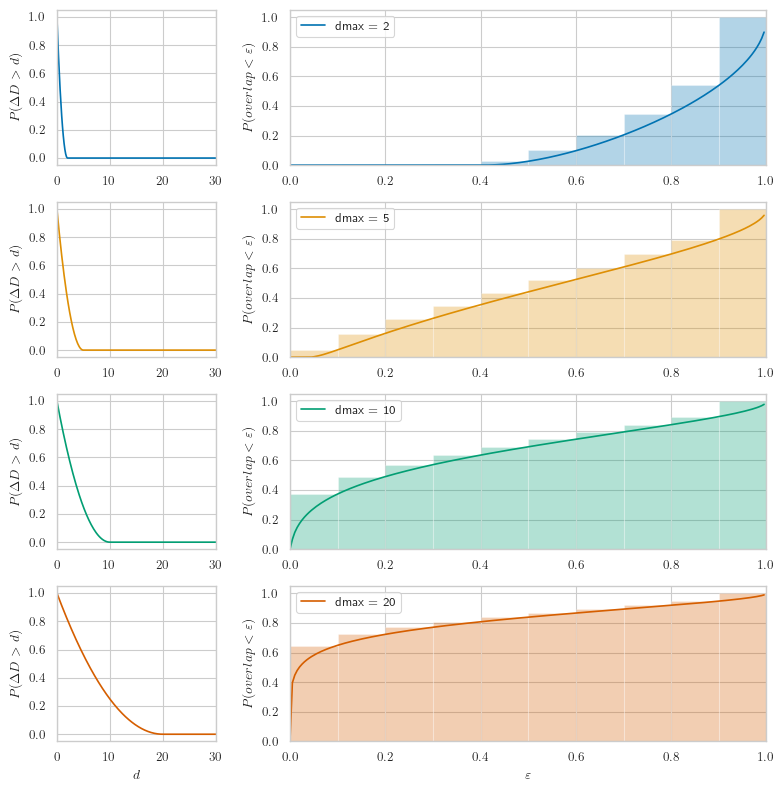

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(8,8), width_ratios=[1, 3])


fun = lambda x: -lambertw(-x / math.e, k=-1).real - 1

eps = np.linspace(0, 1, 200)
for i, dmax in enumerate([2, 5, 10, 20]):
    d = np.linspace(0, 30, 200)
    axes[i,0].plot(d, 1 - (dmax**2 - (dmax - np.clip(d, 0, dmax))**2)/dmax**2, color=f"C{i}", label=f"dmax = {dmax}")
    axes[i,0].set_ylabel(r"$P(\Delta D > d)$")
    axes[i,0].set_xlim(0,30)

    overlaps = np.array([])
    for _ in range(1000):
        delays = np.random.uniform(0, dmax, size=10)
        pairs = np.fromiter(combinations(delays, 2), np.dtype((float, 2)))
        diff = np.abs(pairs[:,0] - pairs[:,1])
        overlaps = np.append(overlaps, (diff+1)*np.exp(-diff))
        
    axes[i,1].plot(eps, np.square((dmax - np.clip(fun(eps), 0, dmax))/dmax), color=f"C{i}", label=f"dmax = {dmax}")

    axes[i,1].hist(overlaps, color=f"C{i}", alpha=0.3, range=(0,1), density=True, cumulative=True)
    axes[i,1].set_ylabel(r"$P(overlap < \varepsilon)$")
    axes[i,1].legend()
    axes[i,1].set_xlim(0,1)
    
axes[-1,0].set_xlabel(r"$d$")
axes[-1,1].set_xlabel(r"$\varepsilon$")

fig.tight_layout()
plt.show()

## Learning Weights

In [8]:
from ipywidgets import interactive

In [9]:
from rsnn.spike_train.sampler import sample_spike_trains

/Users/haguettaz/Documents/RSNN/src/rsnn/spike_train/sampler.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [10]:
period, firing_rate = 50, 0.2

In the limit $L \to \infty$, every neuron has a negligible probability of having parallel connection.
(However, at the network level, the probability that at least one neuron has two parallel connections is almost sure.)

In [11]:
num_inputs = 400

neuron = Neuron(0, num_inputs)
neuron.sources = np.arange(num_inputs)
neuron.delays = np.zeros(num_inputs)

firing_times = sample_spike_trains(period, firing_rate, 1)[0]

input_firing_times = sample_spike_trains(period, firing_rate, num_inputs)

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/400 [00:00<?, ?it/s]

In [12]:
N = 500

A = []
b = []
for t in np.linspace(0, period, N):
    dist_left = np.min((t - firing_times) % period)
    dist_right = np.min((firing_times - t) % period)

    if dist_left < 1e-2:
        A.append([-np.sum(neuron.input_kernel((t - input_firing_times[k]) % period)) for k in range(num_inputs)])
        b.append(-neuron.nominal_threshold)
    elif (dist_left > 1.0):
        A.append([np.sum(neuron.input_kernel((t - input_firing_times[k]) % period)) for k in range(num_inputs)])
        if (dist_right <= 0.2):
            b.append(neuron.nominal_threshold)
        else:
            b.append(0.0)
        
A = np.array(A)
b = np.array(b)

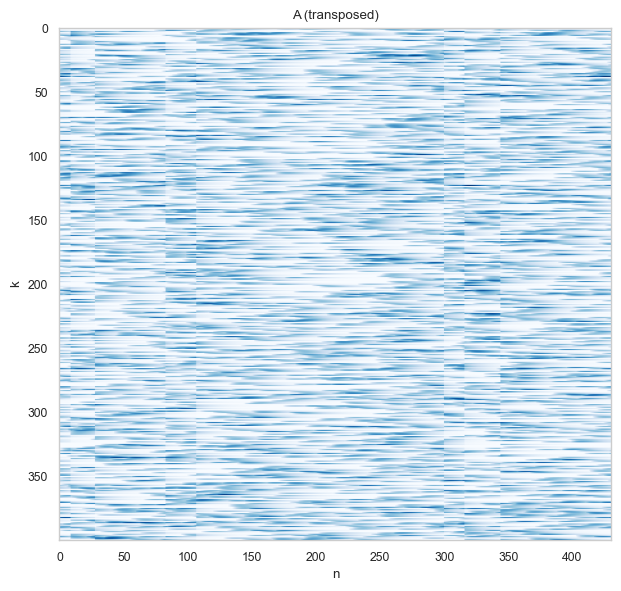

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.imshow(A.T, vmin=0, cmap="Blues")
axes.set_title("A (transposed)")
axes.set_xlabel("n")
axes.set_ylabel("k")
axes.grid(False)

fig.tight_layout()
plt.show()

In [14]:
neuron.optimize_weights(firing_times, input_firing_times, period, weight_bound=0.2, weight_regularization="l2")
neuron.status

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20


'optimal'

In [15]:
def fun(t, derivative=False):
    fig, axes = plt.subplots(1, 3, figsize=(10,3), width_ratios=[3,3,2])
    if derivative:
        y = [np.sum(neuron.input_kernel_prime((t - input_firing_times[k]) % period)) for k in range(num_inputs)]
    else:
        y = [np.sum(neuron.input_kernel((t - input_firing_times[k]) % period)) for k in range(num_inputs)]

    dist_left = np.min((t - firing_times) % period)
    dist_right = np.min((firing_times - t) % period)
    
    min_value = -np.inf
    max_value = np.inf

    if derivative:
        if (dist_left <= 0.2) or (dist_right <= 0.2):
            min_value = 2
    else:
        if dist_left < 1e-2:
            min_value = 1.0
        elif (dist_left > 1.0):
            if (dist_right <= 0.2):
                max_value = 1.0
            else:
                max_value = 0.0

    z = np.inner(y, neuron.weights)
    color = "C2" if (z > min_value) and (z < max_value) else "C3"
    
    axes[0].scatter(np.arange(num_inputs), y, color=color, s=5)
    axes[0].set_ylim(-3, 3)
    axes[0].set_xlabel("k")
    axes[0].set_title("inputs derivative" if derivative else "inputs")
    
    axes[1].scatter(np.arange(num_inputs), neuron.weights, color=color, s=5)
    axes[1].set_ylim(-0.5, 0.5)
    axes[1].set_xlabel("k")
    axes[1].set_title("weights")

    axes[2].fill_between([-10, np.maximum(min_value, -10)], 0, 1, color="C3", alpha=0.5)
    axes[2].fill_between([10, np.minimum(max_value, 10)], 0, 1, color="C3", alpha=0.5)
    axes[2].axvline(z, color=color)
    axes[2].axvline(0 if derivative else 1.0, color="black", linestyle="dashed")
    axes[2].set_xlim(-10, 5)
    axes[2].set_ylim(0, 1)
    axes[2].set_title("potential derivative" if derivative else "potential")
    #axes[2].set_title("forbidden region")
    axes[2].axes.get_yaxis().set_visible(False)
        
    fig.tight_layout()    
    plt.show()

In [17]:
interactive_plot = interactive(fun, t=(0, period, 1e-2), derivative=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=25.0, description='t', max=50.0, step=0.01), Checkbox(value=False, des…

In [18]:
firing_times

array([ 0.85224534,  3.76711093, 10.22061419, 13.54012424, 33.93546375,
       36.52679513, 40.29879138])

The feasible set can be expressed as the set of $w$ satisfying $A w < b$.

In [170]:
num_neurons, num_inputs = 20, 400

neuron = Neuron(0, num_inputs)
neuron.sources = np.random.choice(num_neurons, num_inputs)
neuron.delays = np.random.uniform(low=0, high=10, size=num_inputs)

spike_trains = sample_spike_trains(period, firing_rate, num_neurons)
firing_times = np.copy(sample_spike_trains(period, firing_rate, 1)[0])
input_firing_times = [(spike_trains[l] + d).reshape(-1) for l, d in zip(neuron.sources, neuron.delays)]

Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3194.44it/s]


The feasible set can be expressed as the set of $w$ satisfying $A w < b$.

In [175]:
N = 500

A = []
#b = []
for t in np.linspace(0, period, N):
    A.append([np.sum(neuron.input_kernel((t - input_firing_times[k]) % period)) for k in range(num_inputs)])
    #dist_left = np.min((t - firing_times) % period)
    #dist_right = np.min((firing_times - t) % period)
#
    #if dist_left < 1e-2:
    #    A.append([-np.sum(neuron.input_kernel((t - input_firing_times[k]) % period)) for k in range(num_inputs)])
    #    b.append(-neuron.nominal_threshold)
    #elif (dist_left > 1.0):
    #    A.append([np.sum(neuron.input_kernel((t - input_firing_times[k]) % period)) for k in range(num_inputs)])
    #    if (dist_right <= 0.2):
    #        b.append(neuron.nominal_threshold)
    #    else:
    #        b.append(0.0)
        
A = np.array(A)
#b = np.array(b)

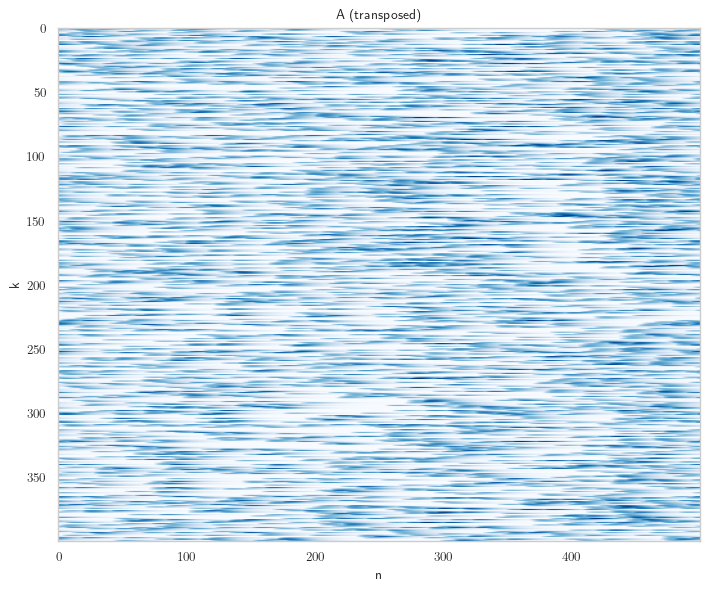

In [176]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

axes.imshow(A.T, vmin=0, cmap="Blues")
axes.set_title("A (transposed)")
axes.set_xlabel("n")
axes.set_ylabel("k")
axes.grid(False)

fig.tight_layout()
plt.show()

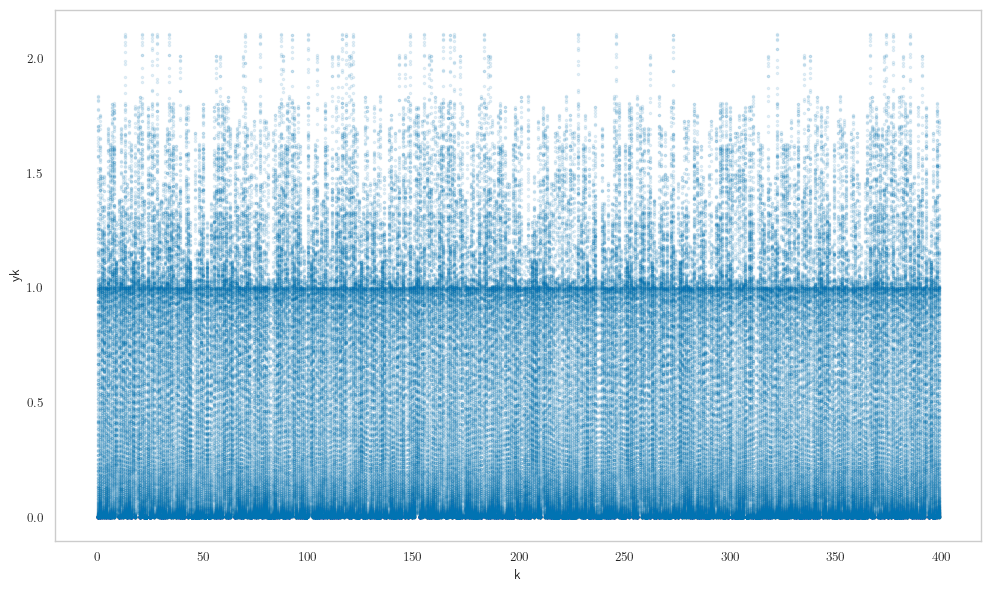

In [185]:
fig, axes = plt.subplots(1, 1, figsize=(10,6))

for k in range(num_inputs):
    axes.scatter(np.full(N, k), A[:, k], s=3, color="C0", alpha=0.1)
axes.set_xlabel("k")
axes.set_ylabel("yk")
axes.grid(False)

fig.tight_layout()
plt.show()

In [186]:
neuron.optimize_weights(firing_times, input_firing_times, period, weight_bound=0.2, weight_regularization="l2")
neuron.status

'optimal'

In [187]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def fun(t, derivative=False):
    fig, axes = plt.subplots(1, 3, figsize=(10,3), width_ratios=[3,3,2])
    if derivative:
        y = [np.sum(neuron.input_kernel_prime((t - input_firing_times[k]) % period)) for k in range(num_inputs)]
    else:
        y = [np.sum(neuron.input_kernel((t - input_firing_times[k]) % period)) for k in range(num_inputs)]

    dist_left = np.min((t - firing_times) % period)
    dist_right = np.min((firing_times - t) % period)
    
    min_value = -np.inf
    max_value = np.inf

    if derivative:
        if (dist_left <= 0.2) or (dist_right <= 0.2):
            min_value = 2
    else:
        if dist_left < 1e-2:
            min_value = 1.0
        elif (dist_left > 1.0):
            if (dist_right <= 0.2):
                max_value = 1.0
            else:
                max_value = 0.0

    z = np.inner(y, neuron.weights)
    color = "C2" if (z > min_value) and (z < max_value) else "C3"
    
    axes[0].scatter(np.arange(num_inputs), y, color=color, s=5)
    axes[0].set_ylim(-3, 3)
    axes[0].set_xlabel("k")
    axes[0].set_title("inputs derivative" if derivative else "inputs")
    
    axes[1].scatter(np.arange(num_inputs), neuron.weights, color=color, s=5)
    axes[1].set_ylim(-0.5, 0.5)
    axes[1].set_xlabel("k")
    axes[1].set_title("weights")

    axes[2].fill_between([-10, np.maximum(min_value, -10)], 0, 1, color="C3", alpha=0.5)
    axes[2].fill_between([10, np.minimum(max_value, 10)], 0, 1, color="C3", alpha=0.5)
    axes[2].axvline(z, color=color)
    axes[2].axvline(0 if derivative else 1.0, color="black", linestyle="dashed")
    axes[2].set_xlim(-10, 5)
    axes[2].set_ylim(0, 1)
    axes[2].set_title("potential derivative" if derivative else "potential")
    #axes[2].set_title("forbidden region")
    axes[2].axes.get_yaxis().set_visible(False)
        
    fig.tight_layout()    
    plt.show()

In [189]:
interactive_plot = interactive(fun, t=(0, period, 1e-2), derivative=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=25.0, description='t', max=50.0, step=0.01), Checkbox(value=False, des…

In [166]:
# What is the distribution of the input signals. Strongly correlated in time...

The effective number of inputs is a function of i) the number of inputs and ii) the support of the input kernels.

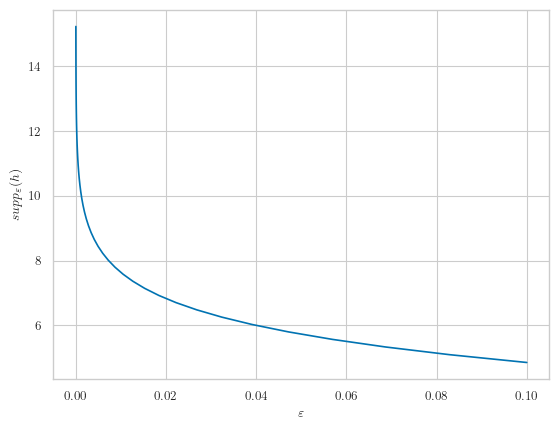

In [43]:
fig, axes = plt.subplots(1, 1)

eps = np.logspace(-5, -1, 50)

axes.plot(eps, np.abs(-lambertw(-eps / math.e, k=-1).real + lambertw(-eps / math.e, k=0).real))
axes.set_xlabel(r"$\varepsilon$")
axes.set_ylabel(r"$supp_\varepsilon(h)$")

plt.show()

In [168]:
def get_num_eff_inputs(delays, sources, eps=1e-2):
    sorted_indices = np.argsort(sources)
    sorted_delays = delays[sorted_indices]
    sorted_sources = sources[sorted_indices]

    _, indices = np.unique(sorted_sources, return_index=True)
    group_delays = np.split(sorted_delays, indices)
    
    length = lambertw(-eps / math.e, k=0).real - lambertw(-eps / math.e, k=-1).real

    list_of_lengths = []
    for grp in group_delays:
        if len(grp) < 1:
            continue

        sorted_grp = np.sort(grp)
        
        tmp_length = length
        end = sorted_grp[0] + length
        for d in sorted_grp[1:]:
            if d < end:
                tmp_length += length - (end - d)
                end = d + length
            else:
                tmp_length += length
                end = d + length
        list_of_lengths.append(tmp_length)

    return sum(list_of_lengths) / length

In [169]:
sources = np.random.choice(10, 5)
delays = np.random.uniform(low=0, high=10, size=5)
get_num_eff_inputs(delays, sources)

4.043206802648163

In [10]:
num_neurons, num_inputs = 20, 400

neuron = Neuron(0, num_inputs)
neuron.sources = np.random.choice(num_neurons, num_inputs)
neuron.delays = np.random.uniform(low=0, high=10, size=num_inputs)
print("num_eff_inputs:", get_num_eff_inputs(neuron.delays, neuron.sources, eps=5e-1))

spike_trains = sample_spike_trains(period, firing_rate, num_neurons)
firing_times = np.copy(sample_spike_trains(period, firing_rate, 1)[0])
input_firing_times = [(spike_trains[l] + d).reshape(-1) for l, d in zip(neuron.sources, neuron.delays)]

neuron.optimize_weights(firing_times, input_firing_times, period, weight_bound=0.2)
print("status:", neuron.status)

NameError: name 'get_num_eff_inputs' is not defined

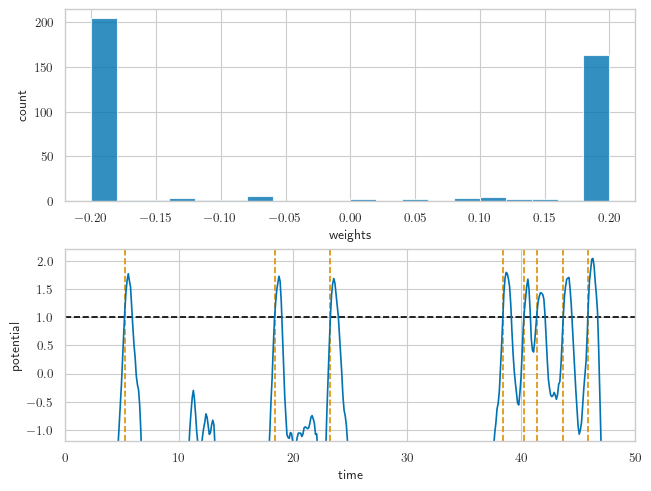

In [199]:
fig = plt.figure(layout="constrained")
subplots = fig.subfigures()

axes = subplots.subplots(nrows=2, ncols=1)

axes[0].hist(neuron.weights, range=(-0.2,0.2), bins=20, alpha=0.8)
axes[0].set_xlabel("weights")
axes[0].set_ylabel("count")

times = np.linspace(0, period, 500)

max_num_spikes = max([fts.size for fts in input_firing_times])
input_firing_times = np.vstack([np.pad(ft, (max_num_spikes - ft.size, 0), constant_values=np.nan) for ft in input_firing_times])

input_potential = lambda t_: np.nansum(neuron.input_kernel((t_[:, None, None] - input_firing_times[None, :, :]) % period), axis=-1)
potential = lambda t_: np.inner(neuron.weights, input_potential(t_))

for s in firing_times:
    axes[1].axvline(s, linestyle="--", c="C1")
axes[1].axhline(neuron.nominal_threshold, linestyle="--", c="black")
axes[1].plot(times, potential(times), c="C0")
axes[1].set_xlim(0, period)
axes[1].set_ylim(-1.2, 2.2)
axes[1].set_xlabel("time")
axes[1].set_ylabel("potential")

plt.show()

In [185]:
num_eff_inputs = int(get_num_eff_inputs(neuron.delays, neuron.sources, eps=1e-1))

neuron = Neuron(0, num_eff_inputs)
neuron.sources = np.arange(num_eff_inputs)
neuron.delays = np.zeros(num_eff_inputs)

firing_times = sample_spike_trains(period, firing_rate, 1)[0]
input_firing_times = sample_spike_trains(period, firing_rate, num_eff_inputs)

neuron.optimize_weights(firing_times, input_firing_times, period, weight_bound=0.2 * num_inputs / num_eff_inputs)
print("status:", neuron.status)

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling:   0%|          | 0/57 [00:00<?, ?it/s]

status: infeasible


In [ ]:
# what is the dimension of the learning problem, i.e., how many inputs do we need?

In [ ]:
input_potential = lambda t_, ift_: np.nansum(self.input_kernel((t_[:, None, None] - ift_[None, :, :]) % period), axis=-1)
input_potential_prime = lambda t_, ift_: np.nansum(
    self.input_kernel_prime((t_[:, None, None] - ift_[None, :, :]) % period),
    axis=-1,
)

# Recurrent Spiking Neural Network

In [4]:
from rsnn.rsnn.rsnn import Network

/Users/haguettaz/Documents/RSNN/src/rsnn/rsnn/rsnn.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [14]:
num_neurons = 10

# inputs
num_synapses = 500
synaptic_decay = 3 # synaptic time constant c_k, e.g., 1/5 ms
somatic_decay = 5 # somatic time constant c_0, e.g., 1/10 ms
weights_lim = (-0.25, 0.25)
delays_lim = (1.0, 10.0)

# spike generation
firing_threshold = 1.0

# refractoriness
hard_refractory_period = 5
soft_refractory_period = 5
soft_refractory_weight = 1.0

In [15]:
network = Network(num_neurons, num_synapses, firing_threshold, synaptic_decay, somatic_decay, delays_lim, hard_refractory_period, soft_refractory_period, soft_refractory_weight, weights_lim)    

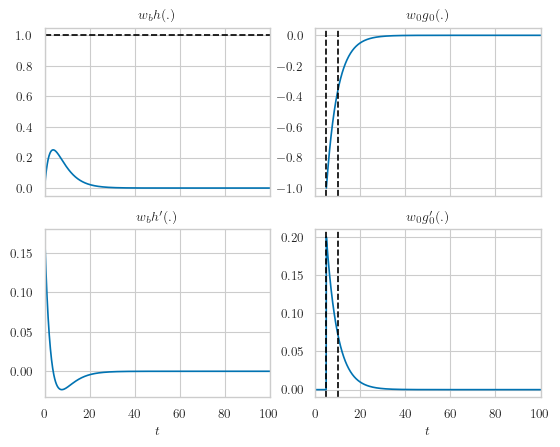

In [16]:
neuron = network.neurons[0]

t = np.linspace(0, 100, 1000)

fig, axes = plt.subplots(2, 2, sharex="all")

#axes[0,0].plot(t, neuron.weights_min * neuron.impulse_resp(t[:,None]), label="$-w_b h(t)$")
axes[0,0].plot(t, neuron.weights_max * neuron.impulse_resp(t[:,None]))
axes[0,0].axhline(neuron.firing_threshold, linestyle="--", color="black")
axes[0,0].set_title("$w_b h(.)$")

axes[0,1].plot(t, neuron.refractory_resp(t[:,None]))
axes[0,1].axvline(neuron.hard_refractory_period, linestyle="--", color="black")
axes[0,1].axvline(neuron.hard_refractory_period + neuron.soft_refractory_period, linestyle="--", color="black")
axes[0,1].set_title("$w_0 g_0(.)$")

#axes[1,0].plot(t, neuron.weights_min * neuron.impulse_resp_deriv(t[:,None]), label="$-w_b h'(t)$")
axes[1,0].plot(t, neuron.weights_max * neuron.impulse_resp_deriv(t[:,None]))
axes[1,0].set_title("$w_b h'(.)$")
axes[1,0].set_xlabel("$t$")
axes[1,0].set_xlim(0, 100)

axes[1,1].plot(t, neuron.refractory_resp_deriv(t[:,None]))
axes[1,1].axvline(neuron.hard_refractory_period, linestyle="--", color="black")
axes[1,1].axvline(neuron.hard_refractory_period + neuron.soft_refractory_period, linestyle="--", color="black")
axes[1,1].set_title("$w_0 g_0'(.)$")
axes[1,1].set_xlabel("$t$")
axes[1,1].set_xlim(0, 100)

plt.show()

In [17]:
from rsnn.rsnn.utils import get_stability_matrix

In [18]:
from rsnn.signals.spike_train import PeriodicSpikeTrain

In [19]:
period = 100
soft_refractory_period = 5
hard_refractory_period = 5
firing_rate = 0.1

In [20]:
spike_train = PeriodicSpikeTrain(num_neurons, period, firing_rate, hard_refractory_period, soft_refractory_period)

In [21]:
spike_train.random()

In [38]:
Phi = get_stability_matrix(network, spike_train)

  0%|          | 0/57 [00:00<?, ?it/s]

In [45]:
np.sort(np.abs(np.linalg.eigvals(Phi)))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.51395792e-09, 1.57060307e-09,
       1.57060307e-09, 1.61722272e-09, 1.66990837e-09, 1.66990837e-09,
       1.70829545e-09, 1.70829545e-09, 1.73309363e-09, 1.73309363e-09,
       1.78061856e-09, 1.78061856e-09, 1.80215872e-09, 1.80922733e-09,
       1.80922733e-09, 1.87231975e-09, 1.89211738e-09, 1.89211738e-09,
       1.89381736e-09, 1.89381736e-09, 1.90492711e-09, 1.92283807e-09,
       1.92283807e-09, 1.92737435e-09, 1.92737435e-09, 1.94058193e-09,
       1.94058193e-09, 1.94849663e-09, 1.94849663e-09, 1.96129087e-09,
       1.96129087e-09, 1.97260097e-09, 1.97260097e-09, 1.98027915e-09,
       1.98027915e-09, 1.99207824e-09, 1.99207824e-09, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
      